In [1]:
!pip install modelsummary
!pip install imgaug --upgrade
import numpy as np
import matplotlib.pyplot as plt
def plot(**kwargs):
    item = kwargs.pop('ax',plt)
    for k,v in kwargs.items():
        if isinstance(v, dict)                                 : o = getattr(item, k)(**v)
        elif isinstance(v, (list, tuple))                      :
            if not any([isinstance(item, dict) for item in v]) : o = getattr(item, k)(*v)
            else:
                _v, _kw = [i for i in v if not isinstance(i, dict)], [i for i in v if isinstance(i, dict)][0]
                o = getattr(item, k)(*_v, **_kw)
        else                                                   : o = getattr(item, k)(v)
    return o

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
device = 'cuda' if torch.cuda.is_available() else 'cpu'

  Created wheel for modelsummary: filename=modelsummary-1.1.7-py3-none-any.whl size=6952 sha256=d88c764ef5677dd4907444e795e3766877490f7fa2911256898343a878154d21
  Stored in directory: /root/.cache/pip/wheels/1f/71/72/680e25ed8958a38a118d9c3c31da31fd2be5144753d97bb66b
Successfully built modelsummary
     |████████████████████████████████| 948 kB 4.7 MB/s 
ERROR: albumentations 0.4.3 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.6
    Uninstalling imgaug-0.2.6:
      Successfully uninstalled imgaug-0.2.6


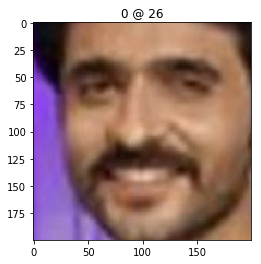

In [2]:
import glob, cv2
files = glob.glob('/kaggle/input/utkface/UTKFace/*.jpg')
f = files[np.random.randint(len(files))]

gen = f.split('/')[-1].split('_')[1]
age = f.split('/')[-1].split('_')[0]
im = cv2.cvtColor(cv2.imread(f,1), cv2.COLOR_BGR2RGB)

plot(imshow={'X':im, 'cmap':'gray'},title=f'{gen} @ {age}');

In [3]:
from imgaug import augmenters as iaa

IMAGE_SIZE = 112
train_transform = iaa.Sequential([
    iaa.geometric.Affine(translate_px=(0,10), rotate=(-10,10), mode='reflect'),
    iaa.flip.Fliplr(0.5),
    iaa.PadToAspectRatio(1.0, pad_mode='reflect'),
    iaa.Sometimes(0.5, iaa.Dropout(0.01)),
    iaa.contrast.LinearContrast(),
    iaa.Sometimes(0.5, iaa.GaussianBlur()),
    iaa.size.Resize(IMAGE_SIZE),
])
validation_transform = iaa.Sequential([
    iaa.PadToAspectRatio(1.0, pad_mode='reflect'),
    iaa.size.Resize(IMAGE_SIZE),
])


class GenderClass(Dataset):
    def __init__(self, fpaths, tfms=None):
        self.fpaths = fpaths
        self.tfm = tfms
        self.mean = np.array([0.485, 0.456, 0.406])
        self.std = np.array([0.229, 0.224, 0.225])
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        gen = f.split('/')[-1].split('_')[1]
        age = f.split('/')[-1].split('_')[0]
        im = cv2.cvtColor(cv2.imread(f,1), cv2.COLOR_BGR2RGB)
        if self.tfm: im = self.tfm(image=im)
        im = (((im/255.) - self.mean)/self.std).astype(np.float32)
        return [np.array(t) for t in [im, int(gen), int(age)//10]]
    
from sklearn.model_selection import train_test_split
trn_fpaths, val_fpaths = train_test_split(files, test_size=0.2)

trn = GenderClass(trn_fpaths, tfms=train_transform)
val = GenderClass(val_fpaths, tfms=validation_transform)

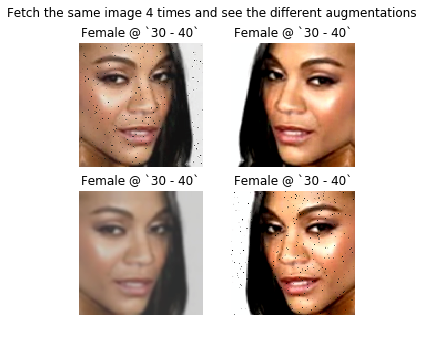

In [4]:
def post_process(gen, age):
    gen = 'Female' if gen else 'Male'
    age = f'`{int(age*10)} - {int((1+age)*10)}`'
    return gen, age

fig, ax = plot(subplots=(2, 2, {'figsize': (5,5)}))
plot(ax=fig, suptitle='Fetch the same image 4 times and see the different augmentations')
ax = iter(ax.flat)
for _ in range(4):
    im, gen, age = trn[0]
    gen, age = post_process(gen, age)
    plot(ax=next(ax), imshow={'X':(255 * ((trn.std * im) + trn.mean)).astype(np.uint8), 'cmap':'gray'}, axis='off', set_title=f'{gen} @ {age}');

In [5]:
device='cuda'
def get_model(**kwargs):
    model = models.vgg11_bn(pretrained = True)
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()
            self.intermediate = nn.Sequential(
                nn.Linear(512,128),
                nn.Dropout(0.4),
                nn.Linear(128,128),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU(),
            )
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 12)
            )
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age
        
    model.classifier = ageGenderClassifier()
    
    gender_criterion = nn.BCELoss()
    age_criterion = nn.CrossEntropyLoss()
    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs.get('lr', 1e-3))
    
    return model.to(device), loss_functions, optimizer

from modelsummary import summary
model, loss_functions, optimizer = get_model()
input = torch.tensor(trn[0][0])[None].permute(0,3,1,2).float().to(device)
print([i.shape for i in model(input)])

summary(model, input, show_hierarchical=True)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/checkpoints/vgg11_bn-6002323d.pth



[torch.Size([1, 1]), torch.Size([1, 12])]
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 1,792 params
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 128 params
    (2): ReLU(inplace=True), 0 params
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), 0 params
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 73,856 params
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
    (6): ReLU(inplace=True), 0 params
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), 0 params
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), 295,168 params
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 512 params
    (10): ReLU(inplace=True), 0 params
    (11): Conv2d(256, 256, kernel_size=(3, 3),

In [6]:
def get_model(**kwargs):
    model = models.resnet18(pretrained = True)
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()
            self.intermediate = nn.Sequential(
                nn.Linear(512,128),
                nn.Dropout(0.4),
                nn.Linear(128,128),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU(),
            )
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 12)
            )
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age
        
    model.fc = ageGenderClassifier()
    
    gender_criterion = nn.BCELoss()
    age_criterion = nn.CrossEntropyLoss()
    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs.get('lr', 1e-3))
    
    return model.to(device), loss_functions, optimizer

from modelsummary import summary
model, loss_functions, optimizer = get_model()
input = torch.tensor(trn[0][0])[None].permute(0,3,1,2).float().to(device)
[i.shape for i in model(input)]

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


[torch.Size([1, 1]), torch.Size([1, 12])]

In [7]:
def preprocess(img, gender, age):
    img = img.permute(0,3,1,2).float().to(device)
    gender, age = [t.to(device) for t in [gender,age]]
    gender = gender.float()
    age = age.long()
    return img, gender, age

def train_batch(img, gender, age, model, optimizer, criteria):
    img, gender, age = preprocess(img, gender, age)
    model.train()
    optimizer.zero_grad()
    _gender, _age = model(img)
    
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(_gender.squeeze(), gender)
    age_loss = age_criterion(_age.squeeze(), age)
    total_loss = gender_loss + age_loss
    total_loss.backward()
    optimizer.step()
    return total_loss

def validate_batch(img, gender, age, model, criteria):
    img, gender, age = preprocess(img, gender, age)
    model.eval()
    with torch.no_grad():
        _gender, _age = model(img)
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(_gender.squeeze(), gender)
    age_loss = age_criterion(_age.squeeze(), age)
    total_loss = gender_loss + age_loss

    _gender = (_gender > 0.5).squeeze()
    _, _age = torch.max(_age, dim=-1)
    return _gender, _age, total_loss

In [8]:
import time

device='cuda'
train_loader = DataLoader(trn, batch_size=256, shuffle=True)
test_loader = DataLoader(val, batch_size=256)
model, criterion, optimizer = get_model()

train_loss, test_loss = [], []
n_epochs = 10

start = time.time()
best_test_loss = 100
for epoch in range(n_epochs):
    epoch_train_loss, epoch_test_loss = 0, 0
    gender_accuracy, age_accuracy, ctr = 0, 0, 0
    _n = len(train_loader)
    for ix, (img,gender,age) in enumerate(train_loader):
        total_loss = train_batch(img, gender, age, model, optimizer, criterion)
        epoch_train_loss += total_loss.item()
        print('{}/{}\tLoss: {:.4f}'.format(ix, _n, total_loss), end='\r')

    for ix, (img,gender,age) in enumerate(test_loader):
        _gender, _age, total_loss = validate_batch(img, gender, age, model, criterion)
        epoch_test_loss += total_loss.item()
        gender_accuracy += (gender.cpu()==_gender.cpu()).sum().float()
        age_accuracy += (age.cpu()==_age.cpu()).sum().float()
        ctr += len(img)

    age_accuracy /= ctr
    gender_accuracy /= ctr
    epoch_train_loss /= len(train_loader)
    epoch_test_loss /= len(test_loader)

    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

    elapsed = time.time()-start
    best_test_loss = min(best_test_loss, epoch_test_loss)
    print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(epoch+1, n_epochs, time.time()-start, (n_epochs-epoch)*(elapsed/(epoch+1))))
    info = f'''Epoch: {epoch+1:03d}\tTrain Loss: {epoch_train_loss:.3f}\tTest: {epoch_test_loss:.3f}\tBest Test Loss: {best_test_loss:.4f}'''
    info += f'\nGender Accruacy: {gender_accuracy*100:.2f}%\tAge Accuracy: {age_accuracy*100:.2f}%\n'
    print(info)


1/10 (177.03s - 1770.33s remaining)
Epoch: 001	Train Loss: 2.428	Test: 1.947	Best Test Loss: 1.9473
Gender Accruacy: 80.56%	Age Accuracy: 42.66%

2/10 (314.37s - 1414.66s remaining)
Epoch: 002	Train Loss: 2.117	Test: 1.865	Best Test Loss: 1.8651
Gender Accruacy: 81.59%	Age Accuracy: 45.30%

3/10 (452.06s - 1205.50s remaining)
Epoch: 003	Train Loss: 2.055	Test: 1.821	Best Test Loss: 1.8210
Gender Accruacy: 82.01%	Age Accuracy: 45.40%

4/10 (588.88s - 1030.55s remaining)
Epoch: 004	Train Loss: 2.035	Test: 1.811	Best Test Loss: 1.8113
Gender Accruacy: 81.76%	Age Accuracy: 45.32%

5/10 (728.32s - 873.98s remaining)
Epoch: 005	Train Loss: 2.015	Test: 1.789	Best Test Loss: 1.7888
Gender Accruacy: 82.24%	Age Accuracy: 46.48%

6/10 (867.66s - 723.05s remaining)
Epoch: 006	Train Loss: 2.005	Test: 1.823	Best Test Loss: 1.7888
Gender Accruacy: 82.22%	Age Accuracy: 46.46%

7/10 (1006.88s - 575.36s remaining)
Epoch: 007	Train Loss: 2.007	Test: 1.777	Best Test Loss: 1.7771
Gender Accruacy: 82.18%	Ag

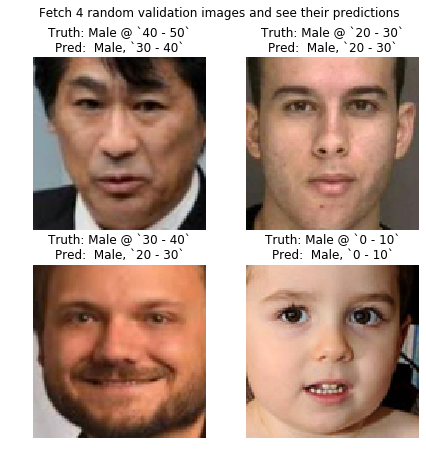

In [9]:
def post_process(gen, age):
    if isinstance(gen, np.ndarray) and isinstance(age, np.ndarray):
        gen = 'Female' if gen else 'Male'
        age = f'`{int(age*10)} - {int((1+age)*10)}`'
    if isinstance(gen, torch.Tensor) and isinstance(age, torch.Tensor):
        gen = 'Female' if gen.item() > 0.5 else 'Male'
        age = torch.max(age, dim=-1)[1].item()
        age = f'`{int(age*10)} - {int((1+age)*10)}`'
    return gen, age

fig, ax = plot(subplots=(2, 2, {'figsize': (7,7)}))
plot(ax=fig, suptitle='Fetch 4 random validation images and see their predictions')
ax = iter(ax.flat)
for _ in range(4):
    im, gen, age = val[np.random.randint(len(val))]
    gen, age = post_process(gen, age)
    _im = (torch.tensor(im)[None]).permute(0,3,1,2).float().to(device)
    _gen, _age = model(_im)
    _gen, _age = post_process(_gen, _age)
    info = f'Truth: {gen} @ {age}\nPred:  {_gen}, {_age}'
    plot(ax=next(ax), imshow={'X':(255 * ((trn.std * im) + trn.mean)).astype(np.uint8), 'cmap':'gray'}, axis='off', set_title=info);